<a href="https://colab.research.google.com/github/aniketmaurya/talks/blob/main/2021-06-27%20PyTorch%20Lightning/02%20flash-intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U 'lightning-flash[image]' -q

In [2]:
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import flash
import pytorch_lightning as pl

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"


In [3]:
from flash import Trainer
from flash.image import ImageClassifier

In [4]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [6]:
class CIFARDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 64):
        super().__init__()
        self.batch_size = batch_size
        
        self.train_data = torchvision.datasets.CIFAR10(
            '/Users/aniket/datasets/', download=True, transform=transform)

        self.val_data = torchvision.datasets.CIFAR10('/Users/aniket/datasets/',
                                                     train=False,
                                                     download=True,
                                                     transform=transform)
        

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_data,
                                           batch_size=self.batch_size,
                                           shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_data,
                                           batch_size=self.batch_size,
                                           shuffle=False)

    def on_after_batch_transfer(self, batch, dataloader_idx):
        data = {'input': batch[0], 'target': batch[1]}
        return data
    
cifar_dm = CIFARDataModule(batch_size=64)


Extracting /Users/aniket/datasets/cifar-10-python.tar.gz to /Users/aniket/datasets/
Files already downloaded and verified


In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

num_classes = len(classes)
backbone = 'resnet18'

model = ImageClassifier(num_classes, backbone)

trainer = flash.Trainer(max_epochs=5, gpus=1)
trainer.fit(model, datamodule=cifar_dm)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name     | Type       | Params
----------------------------------------
0 | metrics  | ModuleDict | 0     
1 | backbone | Sequential | 11.2 M
2 | head     | Sequential | 5.1 K 
----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/lightning.py:169: LightningDeprecationWarning: The `LightningModule.datamodule` property is deprecated in v1.3 and will be removed in v1.5. Access the datamodule through using `self.trainer.datamodule` instead.
  "The `LightningModule.datamodule` property is deprecated in v1.3 and will be removed in v1.5."


## Prediction

In [8]:
data = next(iter(cifar_dm.train_dataloader()))

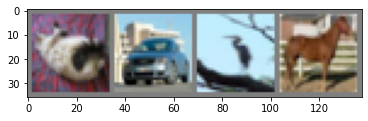

  cat   car  bird horse


In [9]:


batch_size = 4
images, labels = data[0][:batch_size], data[1][:batch_size]


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [10]:
labels

tensor([3, 1, 2, 7])

In [11]:
torch.argmax(torch.nn.Softmax()(model(images)), 1)

tensor([3, 9, 0, 7])